In [3]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from latex import set_size

plt.style.use("tex")
sns.set_palette("colorblind")

datadir = "../data/"
figdir = "../figures/"

beta = 1.66e-11
R = np.sqrt(9.81*4000)/1e-4

alpha = 2.287e-11*4000/1e-4/2
print(alpha)

0.0004574


In [108]:
def compute_c_group_l0(R,beta,k):
    cg=beta*(k**2-1/R**2)/(k**2+1/R**2)**2 # l equal to zero
    return cg

def compute_c_group(R,beta,k):
    cg=beta*(k**2-1/R**2)/(2*k**2+1/R**2)**2 # l included and equal to k (c computed with l equal to k)
    return cg

In [147]:
def find_maximums(da, intervals):
    maximums = []
    for interval in intervals:
        da_sel = da.sel(time=slice(interval[0], interval[1]))
        maximum = da_sel.where(da_sel==da_sel.max(), drop=True).squeeze()
        maximums.append(maximum)
    return maximums

def find_maximums_alt(da, intervals):
    da_i = da.sel(x=0, method="nearest")
    da_f = da.sel(x=slice(-0.5e6, 0.5e6))
    da_sel_i = da_i.sel(time=slice(intervals[0][0], intervals[0][1]))
    maximum_i = da_sel_i.where(da_sel_i==da_sel_i.max(), drop=True).squeeze()
    
    da_sel_f = da_f.sel(time=slice(intervals[1][0], intervals[1][1]))
    da_sel_f = da_sel_f.sel(x=da.x.min(), method="nearest")
    maximum_f = da_sel_f.where(da_sel_f==da_sel_f.max(), drop=True).squeeze()
    
    return [maximum_i, maximum_f]

def slope(x1, x2):
    return (x1.x - x2.x)/(x1.time - x2.time)

def compute_k(Lw):
    k=(1.3*np.pi/Lw)/np.sqrt(5)
    return k

def compute_Lw(Lw):
    return np.sqrt(9.81*4000)/1e-4*Lw

def analytical_group_velocity(k):
    beta = 1.66e-11
    R2 = 9.81*4000/1e-4**2
    return beta*(k**2 - 1/R2)/(k**2 + 1/R2)**2

def analytical_phase_velocity(k):
    beta = 1.66e-11
    R2 = 9.81*4000/1e-4**2
    return -beta/(k**2 + 1/R2)

In [148]:
names = ["025", "050", "075", "1", "125"]
Lws = np.array([0.25, 0.50, 0.75, 1, 1.25])
datasets = []
for i in range(len(names)):
    names[i] = "h_Lw" + names[i]
    ds = xr.open_dataset(datadir + names[i] + ".nc")
    ds = ds.rename(h=names[i])
    datasets.append(ds)
ds = xr.merge(datasets)
ds


<xarray.Dataset>
Dimensions:  (time: 121, x: 300, y: 300)
Coordinates:
  * x        (x) float64 -3.488e+06 -3.465e+06 ... 3.465e+06 3.488e+06
  * y        (y) float64 -4.072e+06 -4.048e+06 ... 2.882e+06 2.905e+06
  * time     (time) float64 0.0 6.0 12.0 18.0 24.0 ... 702.0 708.0 714.0 720.0
Data variables:
    h_Lw025  (time, y, x) float32 ...
    h_Lw050  (time, y, x) float32 ...
    h_Lw075  (time, y, x) float32 ...
    h_Lw1    (time, y, x) float32 ...
    h_Lw125  (time, y, x) float32 ...

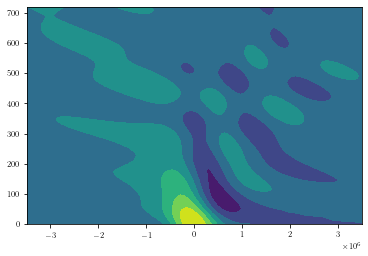

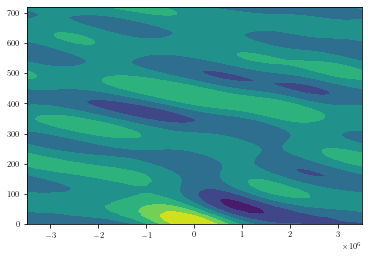

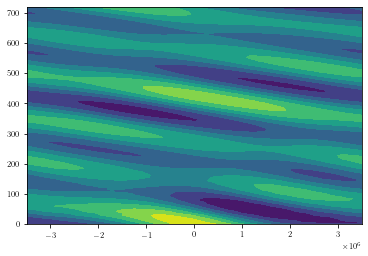

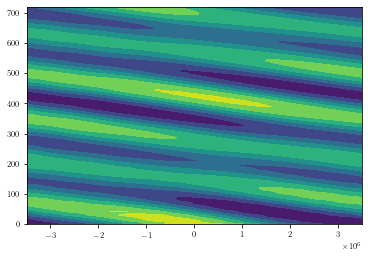

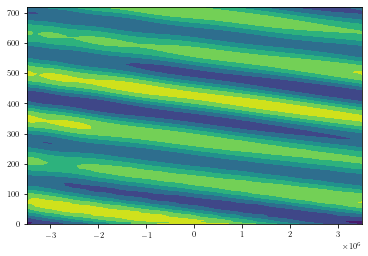

In [149]:
for name in names:
    fig, ax = plt.subplots(1, 1)
    ax.contourf(ds_eq.x, ds_eq.time, ds_eq[name])

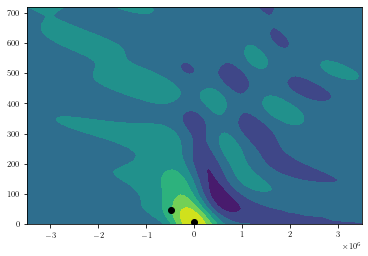

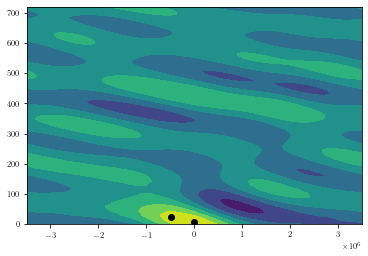

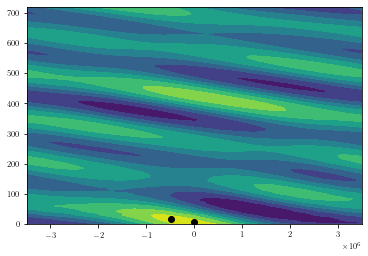

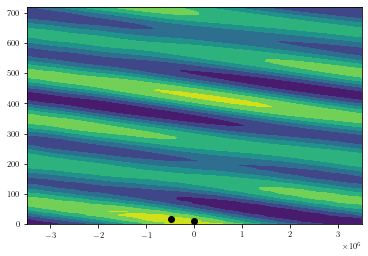

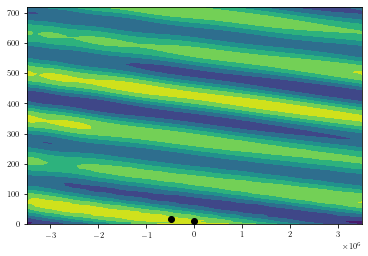

In [154]:
ds_eq = ds.sel(y=0, method="nearest")

intervals = [
            [1, 100],
            [100, 200]
            ]
intervals_alt = [
            [1, 150],
            [15, 150]
            ]
maximums = []
maximums_alt = []
for name in names:
    maximum = find_maximums(ds_eq[name], intervals)
    maximum_alt = find_maximums_alt(ds_eq[name], intervals_alt)
    maximums.append(maximum)
    maximums_alt.append(maximum_alt)
    
    fig, ax = plt.subplots(1, 1)
    ax.contourf(ds_eq.x, ds_eq.time, ds_eq[name])
    ax.plot(maximum_alt[0].x, maximum_alt[0].time, "o", color="black")
    ax.plot(maximum_alt[1].x, maximum_alt[1].time, "o", color="black")

[-0.8101852162679036, 4.6210569882491, 7.5617286844135805, 8.353910783179012, 19.876543402777777]
[3.68810872e-06 1.84405436e-06 1.22936957e-06 9.22027180e-07
 7.37621744e-07]


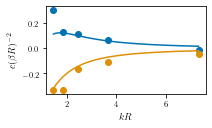

In [155]:
group_velocities = []
phase_velocities = []
for maximum, maximum_alt in zip(maximums, maximums_alt):
    group_velocity = slope(maximum[1], maximum[0])/60/60
    group_velocities.append(float(group_velocity.values))
    
    phase_velocity = slope(maximum_alt[1], maximum_alt[0])/60/60
    phase_velocities.append(float(phase_velocity.values))
print(group_velocities)

ks = compute_k(compute_Lw(Lws))
print(ks)

k = np.linspace(ks[0], ks[-1], 100)

fig, ax = plt.subplots(1, 1, figsize=set_size(width=221))

ax.scatter(ks*R, group_velocities/(beta*R**2))
ax.scatter(ks*R, phase_velocities/(beta*R**2))

ax.plot(k*R , analytical_group_velocity(k)/(beta*R**2))
ax.plot(k*R, analytical_phase_velocity(k)/(beta*R**2))

ax.set_xlabel(r"$k R$")
ax.set_ylabel(r"$c (\beta R)^{-2}$")

fig.tight_layout()
fig.savefig(figdir + "velocities.pdf", dpi=600, bbox_inches="tight")